In [1]:
from transformers import BertTokenizer, BertModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

DATA_PATH = "./data/"

In [11]:
class FeatureExtractor:
    def __init__(self):
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')

    def get_bert_embedding(self, text):
        tokenziers = self.bert_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device='cpu')
        with torch.no_grad():
            output = self.bert_model(**tokenziers)
        return output[0][:, 0, :].squeeze(0).numpy()

    def get_bert_similarty(self, text1, text2):
        embedding1 = self.get_bert_embedding(text1)
        embedding2 = self.get_bert_embedding(text2)
        return cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0][0]

    def get_bert_similarty_list(self, text, text_list):
        embedding = self.get_bert_embedding(text)
        embedding_list = [self.get_bert_embedding(t) for t in text_list]
        return cosine_similarity(embedding.reshape(1, -1), embedding_list)[0]

In [12]:
with open(DATA_PATH + "tags.txt", "r") as f:
    data = f.readlines()
print(data)

['#간식좋아함\n', '#장난감좋아함\n', '#고령의펫\n', '#추위탐\n', '#더위탐\n', '#체중조절필요\n', '#야행성펫\n', '#산책좋아함\n', '#운동러버\n', '#소프트간식굿\n', '#딱딱한간식굿\n', '#푹신한물건굿\n', '#피부민감\n', '#건조한피부\n', '#빛민감\n', '#순한샴푸필수\n', '#온도민감\n', '#털빠짐주의\n', '#사냥본능\n', '#냄새에민감\n', '#물놀이좋아함\n', '#새벽활동러\n', '#높은곳좋아함\n', '#털관리필수\n', '#집을좋아함\n', '#혼자놀기왕\n', '#사교성좋음\n', '#곤충스낵러버\n', '#다이어트필요\n', '#기술학습빠름\n', '#움직이기싫음\n', '#하루종일놀기\n', '#배변훈련필요\n', '#소리좋아함\n', '#감촉민감\n', '#관절보호필요\n', '#인형좋아함\n', '#자주목욕필요\n', '#거친털\n', '#부드러운털\n', '#숲속좋아함\n', '#모래놀이팬\n', '#길들이기쉬움\n', '#길들이기힘듦\n', '#소리에예민\n', '#무서움잘느낌\n', '#다양한맛탐색\n', '#피부알러지있음\n', '#스트레스관리필요']


In [13]:
for idx, word in enumerate(data):
    word_temp = str()
    word_temp = word.replace("\n", "")
    word_temp = word_temp.replace(" ", "")

    if word_temp == "" or word_temp == " " or word_temp == "\n":    continue
    data[idx] = word_temp
print(data)

['#간식좋아함', '#장난감좋아함', '#고령의펫', '#추위탐', '#더위탐', '#체중조절필요', '#야행성펫', '#산책좋아함', '#운동러버', '#소프트간식굿', '#딱딱한간식굿', '#푹신한물건굿', '#피부민감', '#건조한피부', '#빛민감', '#순한샴푸필수', '#온도민감', '#털빠짐주의', '#사냥본능', '#냄새에민감', '#물놀이좋아함', '#새벽활동러', '#높은곳좋아함', '#털관리필수', '#집을좋아함', '#혼자놀기왕', '#사교성좋음', '#곤충스낵러버', '#다이어트필요', '#기술학습빠름', '#움직이기싫음', '#하루종일놀기', '#배변훈련필요', '#소리좋아함', '#감촉민감', '#관절보호필요', '#인형좋아함', '#자주목욕필요', '#거친털', '#부드러운털', '#숲속좋아함', '#모래놀이팬', '#길들이기쉬움', '#길들이기힘듦', '#소리에예민', '#무서움잘느낌', '#다양한맛탐색', '#피부알러지있음', '#스트레스관리필요']


In [14]:
data_df = pd.DataFrame(data={
    'hashtag': data,
}, 
columns=['hashtag'],
index=range(len(data)))

data_df.head(10)

,hashtag
0,#간식좋아함
1,#장난감좋아함
2,#고령의펫
3,#추위탐
4,#더위탐
5,#체중조절필요
6,#야행성펫
7,#산책좋아함
8,#운동러버
9,#소프트간식굿


In [15]:
data_df.shape

(49, 1)

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(data_df['hashtag'])
print(f"tfidf_matrix shape: {tfidf_matrix.shape}")

tfidf_matrix shape: (49, 49)


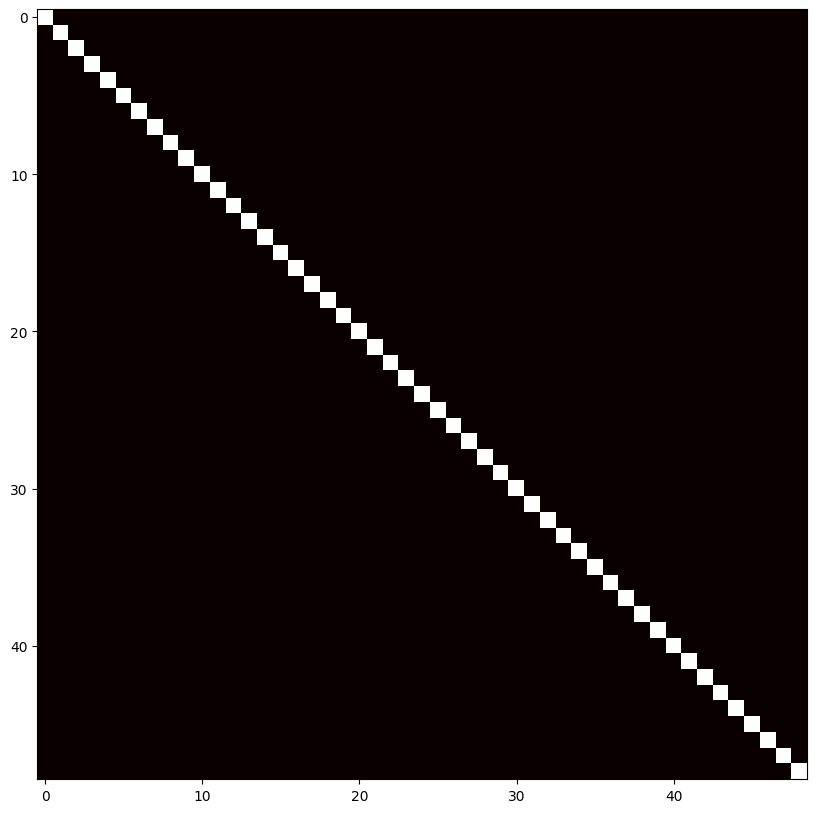

In [17]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

plt.figure(figsize=(10,10))
plt.imshow(cosine_sim, cmap='hot', interpolation='nearest')
plt.show()

In [18]:
extractor = FeatureExtractor()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
bert_sim_list = []
for text in tqdm(data_df['hashtag'].tolist()):
    for text_target in data_df['hashtag'].tolist():
        similarity = extractor.get_bert_similarty(text, text_target)
        bert_sim_list.append(similarity)

bert_sim_list = np.array(bert_sim_list).reshape(len(data_df), len(data_df))
bert_sim_df = pd.DataFrame(bert_sim_list, columns=data_df['hashtag'].tolist(), index=data_df['hashtag'].tolist())

100%|██████████| 49/49 [02:58<00:00,  3.64s/it]


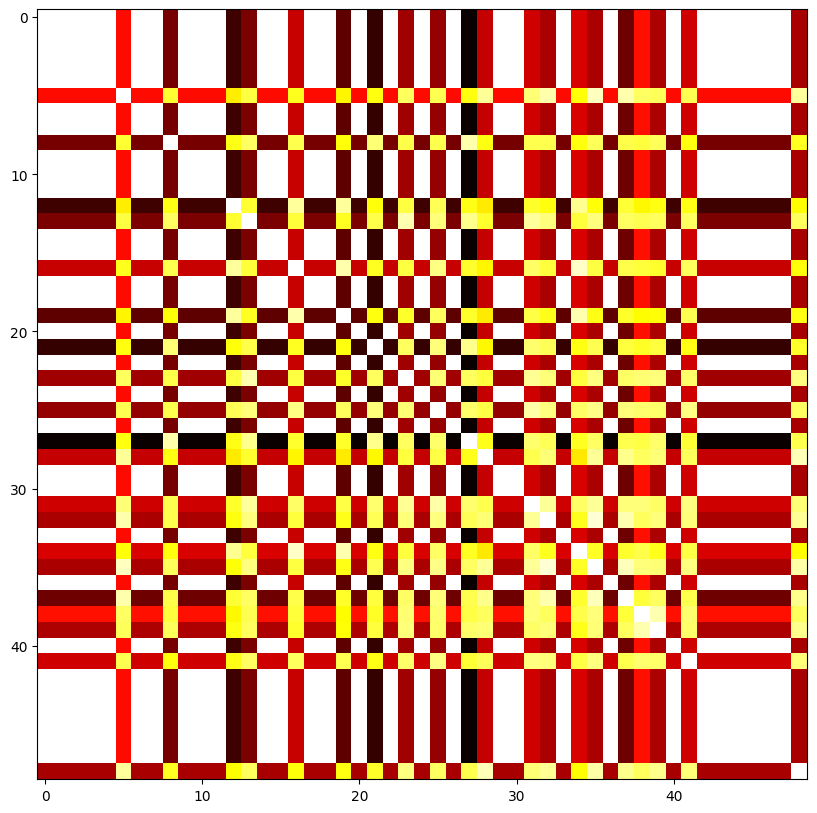

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(bert_sim_list, cmap='hot', interpolation='nearest')
plt.show()

# Test

In [21]:
test_text = "#길들이기힘듦"
test_text = test_text.replace("#", "")
test_text = test_text.split(" ")

sim = extractor.get_bert_similarty_list(test_text, data_df['hashtag'].tolist())
sim = pd.DataFrame({'hashtag': data_df['hashtag'].tolist(), 'similarty': sim})
sim = sim.sort_values(by=['similarty'], ascending=False)

sim

,hashtag,similarty
0,#간식좋아함,0.922983
36,#인형좋아함,0.922983
22,#높은곳좋아함,0.922983
1,#장난감좋아함,0.922983
26,#사교성좋음,0.922983
29,#기술학습빠름,0.922983
30,#움직이기싫음,0.922983
33,#소리좋아함,0.922983
40,#숲속좋아함,0.922983
18,#사냥본능,0.922983
